In [1]:
from mumax_helper import *

from scipy.signal import find_peaks

In [45]:
# NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
fmax = 1e9        # maximum frequency (in Hz) of the sinc pulse
T = 3e-9       # simulation time (longer -> better frequency resolution)
dt = 1e-10  # the sample time (Nyquist theorem taken into account)
side_length = 300e-9  # diameter of the circle domain
fdrive = 750e8
nx = 128
ny = 128
nz = 1


# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.

def resonance_script(field, freq):

    side = 300e-9 

    script = f"""
    setgridsize(200,200,1)
    setcellsize(1e-9,1e-9,1e-9)

    domain := square(300e-9)
    corner1 := xrange(0,inf).rotz(pi/6).transl(0,75e-9,0)
    corner2 := xrange(-inf,0).rotz(-pi/6).transl(0,75e-9,0)

    setgeom(domain.sub(corner1).sub(corner2))

    Msat = 1e6
    Aex = 10e-12
    Dind = 2.2e-3
    Ku1 = 1e6
    AnisU = vector(0,0,1)
    alpha = 0.001

    // B_ext = vector(0, 0, {field} * sinc( 2*pi*{freq}*t)) 
    B_ext = vector(0, 0, {field} * sin( 2*pi*{freq}*t)) 
    TableAdd(B_ext)

    m = NeelSkyrmion(1,-1)

    minimize()
    autosave(m,{dt})
    tableautosave({dt})
    run({T})
    """

    return script

run_mumax3(resonance_script(.01, fmax),
                             "Triangle Drive Slow")


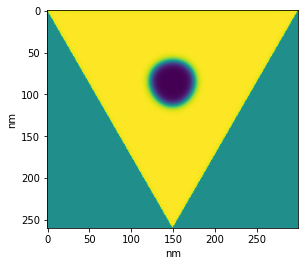

In [42]:
fields = read_mumax3_ovffiles(
    r"C:\Users\foile\OneDrive - University of Illinois - Urbana\Research\Calculations\Triangle Drive.out")
m = np.stack([fields[key] for key in sorted(fields.keys())])
for x in range(len(m)):
    m0 = m[x]

    m0z = m0[2]

    plt.imshow(m0z[0])
    plt.xlabel('nm')
    plt.ylabel('nm')
    label = r"Triangle Drive.out/" + "mz" + str(x) + ".png"
    plt.savefig(label, facecolor='white')


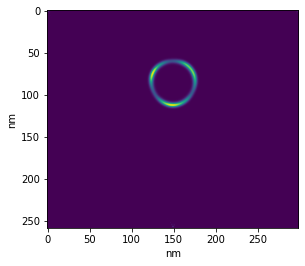

In [43]:
for x in range(len(m)):
    m0 = m[x]

    m0x = m0[0]
    m0y = m0[1]
    m0z = m0[2]

    dm0x_dx = np.diff(m0x,axis=1)[:,:,:-1]
    dm0y_dx = np.diff(m0y,axis=1)[:,:,:-1]
    dm0z_dx = np.diff(m0z,axis=1)[:,:,:-1]

    dm0x_dy = np.diff(m0x,axis=2)[:,:-1,:]
    dm0y_dy = np.diff(m0y,axis=2)[:,:-1,:]
    dm0z_dy = np.diff(m0z,axis=2)[:,:-1,:]

    dm0_dx = np.array([dm0x_dx,dm0y_dx,dm0z_dx])
    dm0_dy = np.array([dm0x_dy,dm0y_dy,dm0z_dy])
    cross_product = np.cross(dm0_dx,dm0_dy,axis=0)

    q_x = m0[0,:,:-1,:-1] * cross_product[0]
    q_y = m0[1,:,:-1,:-1] * cross_product[1]
    q_z = m0[2,:,:-1,:-1] * cross_product[2]
    q = (q_x + q_y + q_z)**4
    plt.imshow(q[0])
    plt.xlabel('nm')
    plt.ylabel('nm')
    label = r"Triangle Drive.out/" + "q" + str(x) + ".png"
    plt.savefig(label,facecolor='white')